In [1]:
import os  # Модуль для взаємодії з операційною системою
import numpy as np  # Бібліотека для роботи з масивами даних
import pandas as pd  # Бібліотека для аналізу та обробки даних у форматі таблиць
import matplotlib.pyplot as plt  # Бібліотека для візуалізації даних

from sklearn.model_selection import KFold, StratifiedKFold  # Модулі для реалізації різних стратегій крос-валідації
from sklearn.linear_model import LogisticRegression  # Логістична регресія - модель класифікації
from sklearn.metrics import classification_report  # Метрики для оцінки якості класифікації

import warnings
warnings.filterwarnings(action="ignore")

## Data Load and Visualizations

In [2]:
df = pd.read_csv(os.path.join("data", "mnist_train.csv"))  # Зчитуємо навчальні дані з CSV файлу
print(df.shape)  # Виводимо розмір таблиці
df.head()  # Виводимо перші декілька записів

(60000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv(os.path.join("data", "mnist_test.csv"))  # Зчитуємо тестові дані з CSV файлу
print(df_test.shape)  # Виводимо розмір таблиці тестових даних
df_test.head()  # Виводимо перші декілька записів тестових даних

(10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


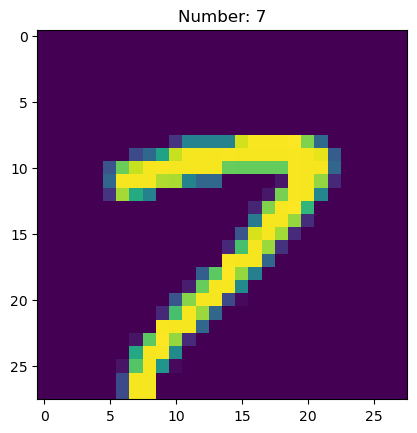

In [4]:
idx = 123  # Індекс зразка, який хочемо візуалізувати
label = df.iloc[idx, 0]  # Отримуємо мітку (цифру) для вибраного зразка
sample = df.iloc[idx, 1:]  # Отримуємо піксельні дані для вибраного зразка
sample = np.reshape(sample, (28, 28))  # Перетворюємо плоский масив у двовимірний зображення розміром 28x28

plt.title(f"Number: {label}")  # Встановлюємо заголовок з міткою (цифрою) зразка
plt.imshow(sample);  # Візуалізуємо зразок

In [5]:
def sample_as_img(sample):
    label = sample[0]  # Отримуємо мітку (цифру)
    img = np.reshape(sample[1:], (28, 28))  # Перетворюємо плоский масив у двовимірний зображення розміром 28x28
    return img, label

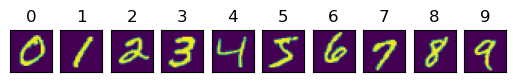

In [6]:
fix, axes = plt.subplots(ncols=10)  # Створюємо сітку з 10 графіками в одному рядку
for i in range(10):
    sample = df[df["label"] == i].iloc[0]  # Вибираємо перший зразок для кожної цифри
    img, label = sample_as_img(sample)  # Отримуємо зображення та мітку для поточного зразка
    ax = axes[i]  # Вибираємо поточний графік з сітки
    ax.imshow(img)  # Візуалізуємо зображення
    ax.set_title(label)  # Встановлюємо заголовок графіку з міткою (цифрою)
    # Приховуємо мітки маркерів X та Y
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    # Приховуємо позначки маркерів X та Y
    ax.set_xticks([])
    ax.set_yticks([])

#### TODO: Data Check

Проаналізуйте дані - візуалізуйте розподіл класів (таргета), візуалізуйте приклади класів.

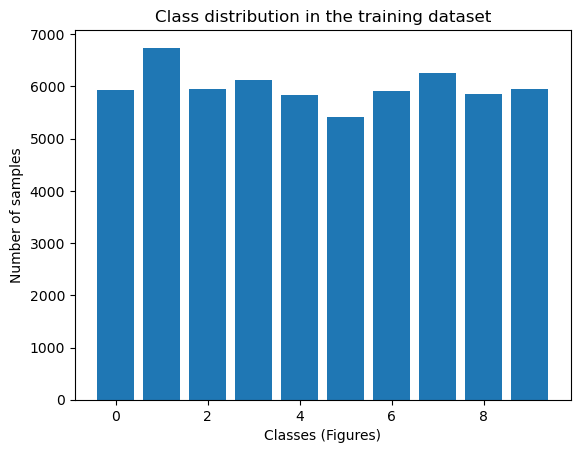

In [7]:
# Візуалізація розподілу класів (таргета)
class_counts = df['label'].value_counts().sort_index()  # кількість зразків у класі
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Classes (Figures)")
plt.ylabel("Number of samples")
plt.title("Class distribution in the training dataset")
plt.show()

Кількість зразків на кожний клас приблизно однакова. Трохи більшою є кількість зразків для одиниці та сімки, що можна пояснити їх схожістю в написанні. Тому для більш точної классифікації надано більше зразків.
Але в цілому розподіл можна вважати рівномірним.

The number of samples for each grade is approximately the same. The number of samples for one and seven is slightly higher, which can be explained by their similarity in spelling. Therefore, more samples were provided for a more accurate classification.
But in general, the distribution can be considered even.

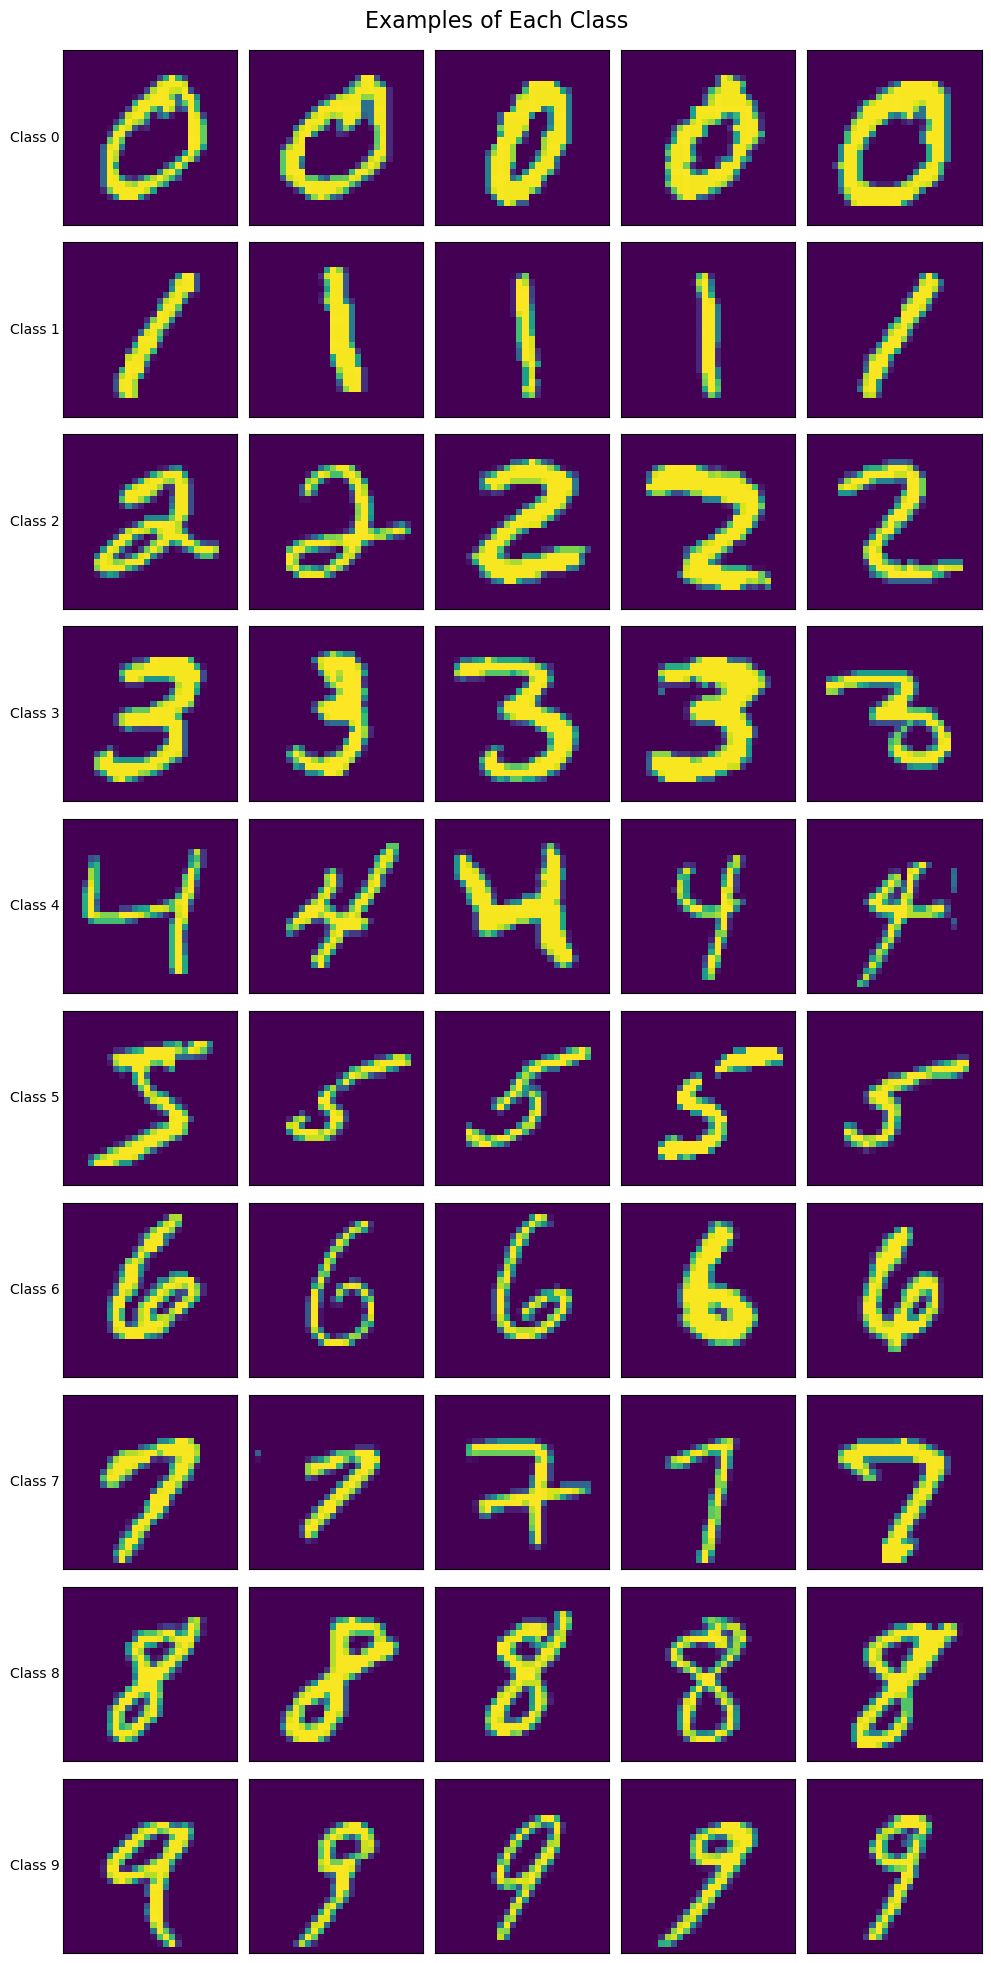

In [8]:
# Візуалізація кількох прикладів для кожного класу
num_classes = 10       # Кількість класів (цифри від 0 до 9)
samples_per_class = 5  # Кількість прикладів для кожного класу

# Створюємо сітку розміром 10х5 (num_classes х samples_per_class)
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class*2, num_classes*2))
for i in range(num_classes):
    # Отримуємо всі зразки для поточного класу
    class_samples = df[df["label"] == i].iloc[:samples_per_class]
    for j in range(samples_per_class):
        sample = class_samples.iloc[j]      # Беремо конкретний зразок
        img, label = sample_as_img(sample)  # Преобразуемо зразок у зображення
        ax = axes[i, j]                     # Вибираємо поточну позицію в сітці
        ax.imshow(img)                      # Відображаємо зразок
        if j == 0:
            ax.set_ylabel(f"Class {label}", rotation=0, labelpad=20, va="center")  # Підписуємо клас
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle("Examples of Each Class\n", fontsize=16)
plt.tight_layout()
plt.show()

## Modeling & Evaluation

#### TODO

На основі розподілу даних оберіть метрику яку оптимізуватимете (accuracy, precision, recall, $F_1$) і напишіть чому саме такий вибір.

Знайдіть модель яка найкраще б працювала на тестових даних (спробуйте різні значення для параметру `penalty : {‘l1’, ‘l2’, ‘elasticnet’, None}`). Напишіть метрики моделей на тестових даних які перевіряли.

In [9]:
# Побудова наборів даних
X = df.iloc[:, 1:].values / 255.0  # Конвертація значень пікселів з діапазону [0..255] до [0,1]
y = df.iloc[:, 0].values  # Вибір міток класів (цифр)

X_test = df_test.iloc[:, 1:].values / 255.0  # Конвертація значень пікселів тестового набору даних з [0..255] до [0,1]
y_test = df_test.iloc[:, 0].values  # Вибір міток класів для тестового набору даних

In [10]:
n_folds = 5  # Кількість фолдів для крос-валідації

for fold_idx, (train_idxs, valid_idxs) in enumerate(KFold(n_splits=n_folds).split(X)):
    x_train, y_train = X[train_idxs], y[train_idxs]  # Отримання тренувального набору
    x_valid, y_valid = X[valid_idxs], y[valid_idxs]  # Отримання валідаційного набору
    model = LogisticRegression(penalty=None)  # Створення моделі логістичної регресії
    model.fit(x_train, y_train)  # Навчання моделі на тренувальних даних
    y_pred = model.predict(x_valid)  # Прогнозування на валідаційних даних
    report = classification_report(y_valid, y_pred)  # Оцінка якості класифікації на валідаційних даних
    print(f"\n[Fold {fold_idx+1}/{n_folds}]")  # Вивід номера фолду
    print(report)  # Вивід звіту про класифікацію для поточного фолду


[Fold 1/5]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1206
           1       0.95      0.97      0.96      1351
           2       0.91      0.90      0.91      1176
           3       0.89      0.89      0.89      1228
           4       0.92      0.94      0.93      1184
           5       0.91      0.88      0.89      1048
           6       0.94      0.96      0.95      1208
           7       0.95      0.92      0.94      1279
           8       0.89      0.85      0.87      1127
           9       0.90      0.92      0.91      1193

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000


[Fold 2/5]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1175
           1       0.96      0.97      0.96      1381
           2       0.90      0.88      0.89      1171


Крос-валідація показала, що модель має хорошу загальну точність (92-93%), але recall для класу "8" (85-89%) є нижчим, ніж у інших класів. Це означає, що модель часто не розпізнає цифру "8", що може бути критично, якщо важливо виявляти всі зразки цього класу.

Тому для покращення роботи моделі ми обираємо оптимізацію <b>recall</b> для класу "8", щоб зменшити кількість пропущених прикладів цієї цифри.
***
The cross-validation showed that the model has good overall accuracy (92-93%), but the recall for the class "8" (85-89%) is lower than for the other classes. This means that the model often fails to recognise the digit "8", which can be critical if it is important to detect all samples of this class.

Therefore, to improve the model's performance, we choose <b>recall</b> optimisation for the "8" class to reduce the number of missed examples of this digit

In [11]:
# model = LogisticRegression(penalty=None)  # Створення моделі логістичної регресії для тестування
# model.fit(X, y)  # Навчання моделі на всіх навчальних даних

# print(classification_report(y_test, model.predict(X_test)))  # Оцінка якості класифікації на тестових даних та виведення звіту

| solver    | Підтримує l1 | Підтримує l2 | Підтримує elasticnet | Великий обсяг даних | Особливості |
|-----------|-------------|-------------|----------------------|---------------------|--------------|
| liblinear | ✅         | ✅         | ❌                  | ❌                 | Хороший для невеликих наборів даних |
| lbfgs     | ❌         | ✅         | ❌                  | ✅                 | Підходить для багатокласової класифікації |
| newton-cg | ❌         | ✅         | ❌                  | ✅                 | Стабільний, але повільний |
| sag       | ❌         | ✅         | ❌                  | ✅                 | Оптимізований для великих даних |
| saga      | ✅         | ✅         | ✅                  | ✅                 | Найкращий для великих даних, підтримує всі регуляризації |


In [16]:
# Список параметрів 'penalty'
penalties = [None, 'l1', 'l2', 'elasticnet']
solver = 'saga'  # 'saga' підтримує всі типи регуляризації

results = []

In [17]:
for penalty in penalties:
    try:
        # Створення моделі логістичної регресії для тестування
        if penalty == "elasticnet":
            model = LogisticRegression(penalty=penalty, solver=solver, max_iter=500, l1_ratio=0.5, random_state=42)
        else:
            model = LogisticRegression(penalty=penalty, solver=solver, max_iter=500, random_state=42)

        # Навчання моделі на всіх навчальних даних
        model.fit(X, y)
        y_pred = model.predict(X_test)

        # Отримання метрик
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        recall_8 = report['8']['recall']  # Оптимізуємо recall для класу "8"
        f1_8 = report['8']['f1-score']    # Також записуємо F1 для "8"

        results.append({
            'penalty': penalty,
            'accuracy': accuracy,
            'recall_8': recall_8,
            'f1_8': f1_8
        })
    except Exception as e:
        results.append({
            'penalty': penalty,
            'error': str(e)
        })


In [18]:
# Виведення таблиці з результатами
results_df = pd.DataFrame(results)
results_df

,penalty,accuracy,recall_8,f1_8
0,None,0.9245,0.883984,0.881720
1,l1,0.9282,0.891170,0.887526
2,l2,0.9257,0.877823,0.879177
3,elasticnet,0.9269,0.885010,0.883197


Модель з L1-регуляризацією (penalty=l1) показала найкращі результати:

| penalty |	accuracy |	recall_8 |	f1_8 |
|---------|-----------|-----------|-------|
|	None |	0.9245 |	0.883984 |	0.881720 |
|	l1 |	0.9282 |	0.891170 |	0.887526 |
|	l2 |	0.9257 |	0.877823 | 0.879177 |
|	elasticnet |	0.9269 |	0.885010 |	0.883197 |


* accuracy = 0.9282 (найвища серед усіх) - модель загалом працює найкраще.
* recall_8 = 0.891170 (найкраща для класу "8") - саме те, що ми оптимізуємо.
* f1_8 = 0.887526 (також найкраще значення) - збалансованість між precision і recall.

ElasticNet (0.9269, 0.885010, 0.883197) хоч і показав трохи кращі результати за None і L2, але програє L1 за всіма метриками.

Це означає, що <b>L1-регуляризація</b> - найкращий вибір для цієї задачі, оскільки вона дає найвищий recall_8, що є нашою цільовою метрикою.